In [171]:
import pandas as pd 
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit




#loading dataset
stock_data = pd.read_csv('./AMZN.csv',index_col='Date')
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-05-24,1835.890015,1841.760010,1817.849976,1823.280029,1823.280029,3369700
2019-05-28,1832.750000,1849.270020,1827.349976,1836.430054,1836.430054,3200000
2019-05-29,1823.119995,1830.000000,1807.530029,1819.189941,1819.189941,4279000
2019-05-30,1825.489990,1829.469971,1807.829956,1816.319946,1816.319946,3146900
2019-05-31,1790.010010,1795.589966,1772.699951,1775.069946,1775.069946,4618800


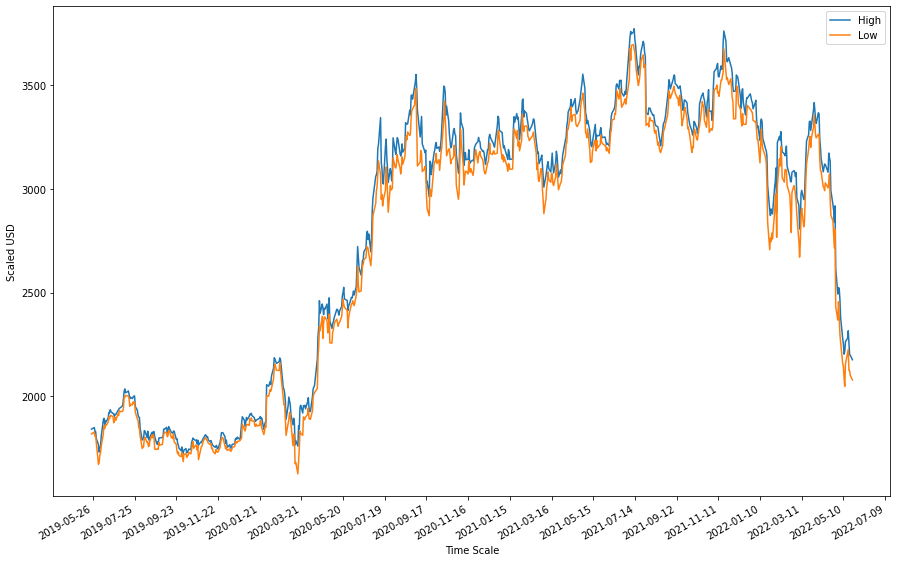

In [172]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
x_dates = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in stock_data.index.values]

plt.plot(x_dates,stock_data['High'],label='High')
plt.plot(x_dates,stock_data['Low'],label='Low')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

In [173]:
#datapreprocessing
target_y  = stock_data.iloc[:,3:4]
X_feat = stock_data.iloc[:,0:3]


#Feature Scaling
sc = StandardScaler()
X_ft = sc.fit_transform(X_feat.values)
X_ft = pd.DataFrame(columns=X_feat.columns,data=X_ft,index=X_feat.index)
y_ft = sc.fit_transform(target_y.values)
y_ft = pd.DataFrame(columns=target_y.columns,data=y_ft,index=target_y.index)


In [174]:
def lstm_split(data,n_steps):
  X,y=[],[]
  for i in range(0,len(data) - n_steps +1):
    X.append(data[i:i + n_steps,:-1])
    y.append(data[i + n_steps-1,-1])

  return np.array(X),np.array(y)


In [175]:
#training_and_testing
stock_data_ft = np.concatenate((X_ft,y_ft),axis=1)
n_steps = 10
X1,y1 = lstm_split(stock_data_ft,n_steps=10)


train_split = 0.8
split_idx = int(np.ceil(len(X1)*train_split))
date_index = X_feat.index

X_train,X_test = X1[:split_idx],X1[split_idx:]
y_train,y_test = y1[:split_idx],y1[split_idx:]
X_train_date,X_test_date = date_index[:split_idx],date_index[split_idx:]

print(X1.shape,X_train.shape,X_test.shape,y1.shape,y_train.shape,y_test.shape)


(747, 10, 3) (598, 10, 3) (149, 10, 3) (747,) (598,) (149,)


In [176]:
#building LSTM Model
lstm = Sequential()
lstm.add(LSTM(50,input_shape=(X_train.shape[1],X_train.shape[2]),activation='sigmoid',return_sequences=True))
lstm.add(LSTM(50,activation='sigmoid'))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error',optimizer='adam')
lstm.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 10, 50)            10800     
                                                                 
 lstm_15 (LSTM)              (None, 50)                20200     
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                                 
Total params: 31,051
Trainable params: 31,051
Non-trainable params: 0
_________________________________________________________________


In [177]:
#fit simple model to training data
history = lstm.fit(X_train,y_train,epochs=100,batch_size=4,verbose=2,shuffle=False)

Epoch 1/100
150/150 - 5s - loss: 0.0819 - 5s/epoch - 33ms/step
Epoch 2/100
150/150 - 1s - loss: 0.4068 - 970ms/epoch - 6ms/step
Epoch 3/100
150/150 - 1s - loss: 0.7972 - 999ms/epoch - 7ms/step
Epoch 4/100
150/150 - 1s - loss: 0.5257 - 981ms/epoch - 7ms/step
Epoch 5/100
150/150 - 1s - loss: 0.0925 - 955ms/epoch - 6ms/step
Epoch 6/100
150/150 - 1s - loss: 0.0316 - 953ms/epoch - 6ms/step
Epoch 7/100
150/150 - 1s - loss: 0.0240 - 969ms/epoch - 6ms/step
Epoch 8/100
150/150 - 1s - loss: 0.0221 - 1000ms/epoch - 7ms/step
Epoch 9/100
150/150 - 1s - loss: 0.0202 - 998ms/epoch - 7ms/step
Epoch 10/100
150/150 - 1s - loss: 0.0183 - 989ms/epoch - 7ms/step
Epoch 11/100
150/150 - 1s - loss: 0.0166 - 1s/epoch - 7ms/step
Epoch 12/100
150/150 - 1s - loss: 0.0151 - 957ms/epoch - 6ms/step
Epoch 13/100
150/150 - 1s - loss: 0.0136 - 1s/epoch - 7ms/step
Epoch 14/100
150/150 - 1s - loss: 0.0124 - 964ms/epoch - 6ms/step
Epoch 15/100
150/150 - 1s - loss: 0.0112 - 960ms/epoch - 6ms/step
Epoch 16/100
150/150 - 1s 

In [178]:
y_pred = lstm.predict(X_test)

print(y_pred[0:10,:],y_test[0:10])

print(y_pred.shape,y_test.shape)
rmse = mean_squared_error(y_test,y_pred,squared=False)
mape = mean_absolute_percentage_error(y_test,y_pred)
print(rmse,mape)

[[1.0071707 ]
 [0.9962891 ]
 [0.9301369 ]
 [0.84680325]
 [0.96844053]
 [0.9750403 ]
 [1.0161787 ]
 [0.8019866 ]
 [0.8970658 ]
 [0.8284722 ]] [1.00371502 1.03432475 0.88172073 0.85842976 0.94389166 0.96908517
 1.05206165 0.9383065  0.85496217 0.84673802]
(149, 1) (149,)
0.06480850658109591 0.23374390981000576


Index(['2021-10-07', '2021-10-08', '2021-10-11', '2021-10-12', '2021-10-13',
       '2021-10-14', '2021-10-15', '2021-10-18', '2021-10-19', '2021-10-20',
       ...
       '2022-04-27', '2022-04-28', '2022-04-29', '2022-05-02', '2022-05-03',
       '2022-05-04', '2022-05-05', '2022-05-06', '2022-05-09', '2022-05-10'],
      dtype='object', name='Date', length=149)


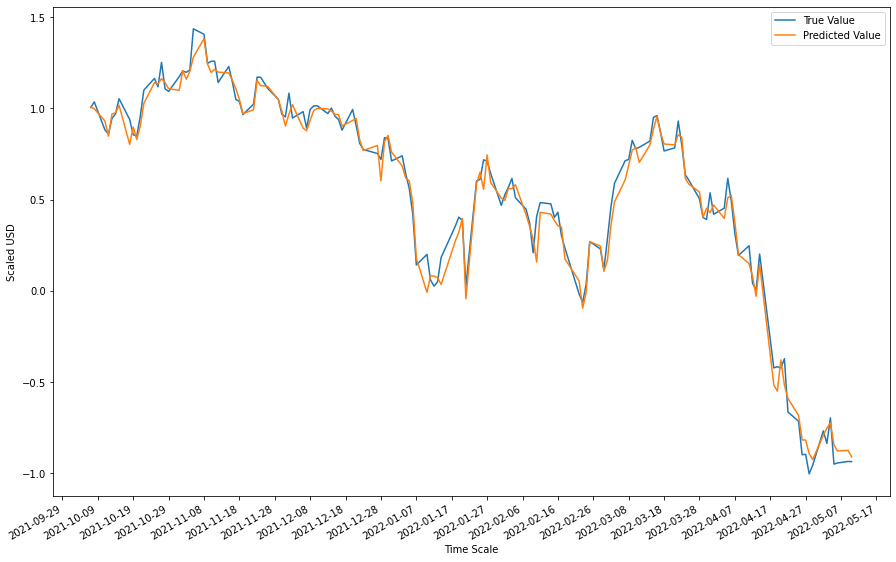

In [191]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))


dates = date_index[0: len(date_index) - n_steps + 1]
x_dates = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates[split_idx:].values]

plt.plot(x_dates,y_test,label='True Value')
plt.plot(x_dates,y_pred,label='Predicted Value')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()